In [1]:
import os
import random
import shutil
import pathlib


In [2]:
# now the task for transfer learning start
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

batch_size = 32
img_height = 224
img_width = 224

IMG_SIZE = (img_height, img_width)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    pathlib.Path("../train"),
    #validation_split=0.2,
    #subset="training",
    #seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="categorical"
    )

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    pathlib.Path("../val"),
    #validation_split=0.2,
    #subset="validation",
    #seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="categorical"
    )

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    pathlib.Path("../test"),
    #validation_split=0.2,
    #subset="validation",
    #seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="categorical"
    )

class_names = train_ds.class_names
print(class_names)


Found 25920 files belonging to 4 classes.
Found 6480 files belonging to 4 classes.
Found 3600 files belonging to 4 classes.
['clear', 'dirty', 'obstruction', 'shadow']


In [3]:
# F1 score functions

from tensorflow.keras import backend as K


def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


In [4]:
# data augmentation

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2, fill_mode="nearest"),
    #tf.keras.layers.experimental.preprocessing.RandomTranslation(0.5, 0.5, fill_mode="wrap"),
    #tf.keras.layers.experimental.preprocessing.RandomZoom(0.5, fill_mode="nearest"),
    #tf.keras.layers.experimental.preprocessing.RandomCrop(100, 100),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.5),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.5),
])


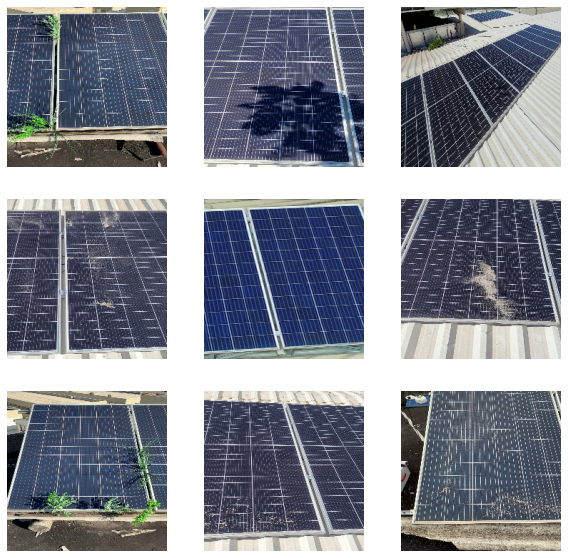

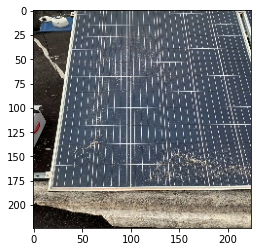

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
image = None
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")
    image = images[i].numpy().astype("uint8")

plt.figure()
plt.imshow(image)


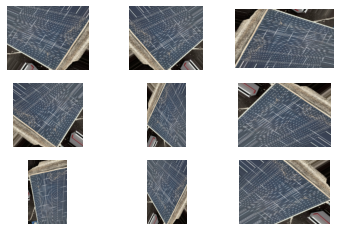

In [6]:
plt.figure()

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [7]:
# https://keras.io/api/applications/
# EfficientNetB7
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

# Create the base model from the pre-trained model  EfficientNetB7
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB7(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

base_model.trainable = False

# Show the model architecture
base_model.summary()

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(
    len(class_names), activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy', f1_m])

model.summary()


258076736/258076736 [==============================] - 51s 0us/step
(32, 7, 7, 2560)
Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  


In [8]:
# first evaluation before training 
model.evaluate(val_ds)



203/203 [==============================] - 82s 363ms/step - loss: 1.3924 - accuracy: 0.1461 - f1_m: 2.9855e-04


[1.3924100399017334, 0.14614197611808777, 0.00029855198226869106]

In [9]:
# training process without fine tunning 
initial_epochs = 20
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)


Epoch 1/20
810/810 [==============================] - 799s 969ms/step - loss: 0.9103 - accuracy: 0.7351 - f1_m: 0.4313 - val_loss: 0.8996 - val_accuracy: 0.7627 - val_f1_m: 0.5322
Epoch 2/20
810/810 [==============================] - 602s 742ms/step - loss: 0.5942 - accuracy: 0.8428 - f1_m: 0.7753 - val_loss: 0.7437 - val_accuracy: 0.8063 - val_f1_m: 0.6904
Epoch 3/20
810/810 [==============================] - 553s 683ms/step - loss: 0.4854 - accuracy: 0.8668 - f1_m: 0.8390 - val_loss: 0.6601 - val_accuracy: 0.8310 - val_f1_m: 0.7453
Epoch 4/20
810/810 [==============================] - 515s 635ms/step - loss: 0.4233 - accuracy: 0.8810 - f1_m: 0.8636 - val_loss: 0.5936 - val_accuracy: 0.8477 - val_f1_m: 0.7799
Epoch 5/20
810/810 [==============================] - 492s 607ms/step - loss: 0.3789 - accuracy: 0.8926 - f1_m: 0.8813 - val_loss: 0.5482 - val_accuracy: 0.8594 - val_f1_m: 0.8102
Epoch 6/20
810/810 [==============================] - 483s 596ms/step - loss: 0.3537 - accuracy: 0.8

In [10]:
# new evaluation after training
model.evaluate(test_ds)


113/113 [==============================] - 36s 316ms/step - loss: 0.3292 - accuracy: 0.9103 - f1_m: 0.9071


[0.32916226983070374, 0.910277783870697, 0.90708988904953]

In [11]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.

base_file_name = "efficientnetb7_tl_au"
model.save(base_file_name + '_model.h5')


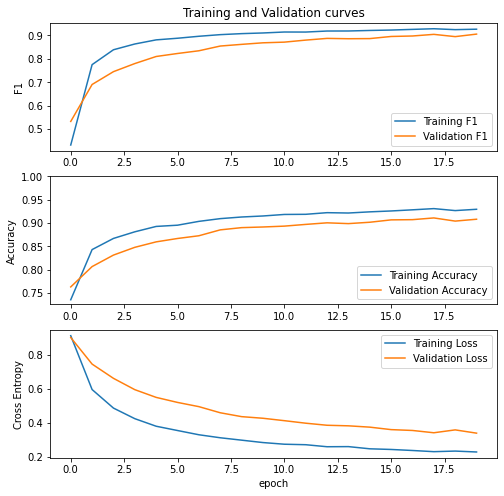

In [12]:
# plot training curves

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

f1 = history.history['f1_m']
val_f1 = history.history['val_f1_m']

loss = history.history['loss']
val_loss = history.history['val_loss']

f = open(base_file_name + "_model.txt", "a")
f.write(f"acurracy\tval_accuracy\tloss\tval_loss\tf1\tval_f1\n")
for i in range(len(acc)):
  f.write(f"{acc[i]}\t{val_acc[i]}\t{loss[i]}\t{val_loss[i]}\t{f1}\t{val_f1}\n")

f.close()

plt.figure(figsize=(8, 8))

plt.subplot(3, 1, 1)
plt.plot(f1, label='Training F1')
plt.plot(val_f1, label='Validation F1')
plt.legend(loc='lower right')
plt.ylabel('F1')
plt.title('Training and Validation curves')
#plt.xlabel('epoch')

plt.subplot(3, 1, 2)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
#plt.title('Training and Validation Accuracy')

plt.subplot(3, 1, 3)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.savefig(
    f"{base_file_name}_model.png"
)
#plt.close()


In [13]:
# contruct prediction vector to make the confusion matrix

predictions = np.array([])
labels = np.array([])
for x, y in test_ds:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=-1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])


1/1 [==============================] - 4s 4s/step


[[687 165  17  31]
 [ 18 870   0  12]
 [  0   3 896   1]
 [  6  51  19 824]]


<Figure size 432x288 with 0 Axes>

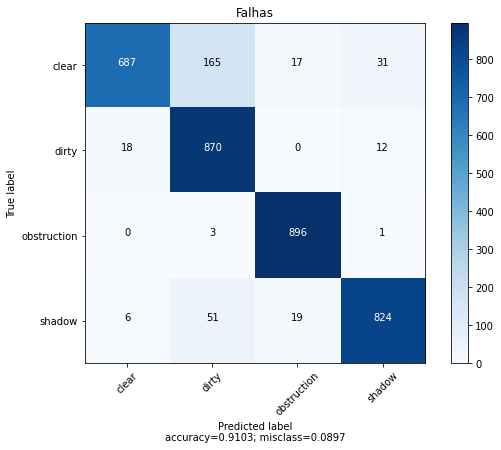

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

M = confusion_matrix(labels, predictions)
print(M)


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    _ = plt.figure()

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(
        accuracy, misclass))
    #plt.show()
    plt.savefig(
        f"{base_file_name}_model_cm.png"
    )


plot_confusion_matrix(M, normalize=False,
                      target_names=test_ds.class_names, title="Falhas")
